In [1]:
%load_ext autoreload
%autoreload 2
import hover as H
from IPython.display import display, update_display
import numpy as np
import itertools as it
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch as T
import time
sns.set_context('talk')

In [ ]:
def plot_lifetime_dist(df):
    plt.figure(figsize=(10, 6))
    bins = np.logspace(np.log10(.6), np.log10(20), 50)
    names = sorted(set(df.name))
    for name in names:
        sns.distplot(df.lifetime[df.name == name], kde=False, bins=bins)
    plt.gca().set_xscale('log')
    plt.legend(names)

In [7]:
class Log:
    def __init__(self):
        self._t = 0
        self._logs = collections.defaultdict(lambda: ([], []))

    def append(self, name, value):
        ts, values = self._logs[name]
        ts.append(self._t)
        values.append(value)
        
    def tick(self):
        self._t += 1
        
    def show(self):
        for name, (ts, values) in self._logs.items():
            plt.figure(figsize=(10, 6))
            plt.scatter(ts, values)
            plt.title(name)

,lifetime
name,
constant_00,1.4800
constant_01,0.8398
constant_10,0.8364
constant_11,1.0333
constant_up_0.25,2.8400
constant_up_0.33,5.1582
constant_up_0.5,2.1376


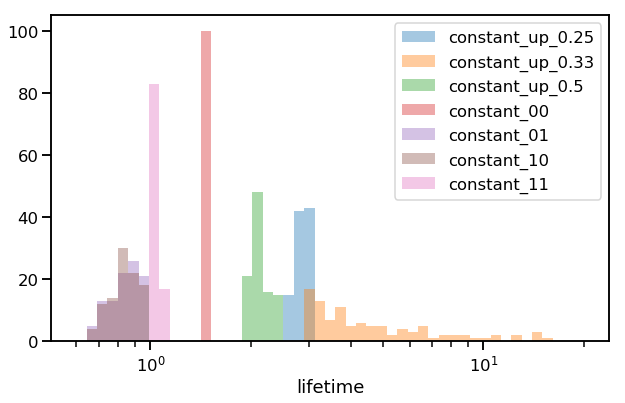

         3227026 function calls (3217887 primitive calls) in 4.269 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   143253    1.297    0.000    1.454    0.000 hover.py:125(step)
   143953    0.577    0.000    1.289    0.000 hover.py:134(state)
      700    0.415    0.001    3.850    0.005 hover.py:148(single_game_lifetime)
   143953    0.224    0.000    0.261    0.000 hover.py:144(in_bounds)
   101358    0.187    0.000    0.212    0.000 hover.py:166(__call__)
   143953    0.112    0.000    0.112    0.000 {built-in method Box2D._Box2D.b2Body___GetPosition}
   143953    0.107    0.000    0.107    0.000 {built-in method Box2D._Box2D.b2Body___GetLinearVelocity}
   143953    0.076    0.000    0.188    0.000 Box2D.py:3909(__GetPosition)
   143253    0.074    0.000    0.126    0.000 Box2D.py:4068(__GetMass)
      700    0.069    0.000    0.207    0.000 hover.py:74(__init__)
   144423    0.061    0.000    0.061    0.000 {built-in

In [5]:
%%prun

agents = dict(
    **{"constant_up_{}".format(f): H.IntegratorController(H.constant_agent(f, f))
       for f in [0.25, 0.33, 0.5]},
    **{"constant_{:02b}".format(i): H.constant_agent(bool(i & 0x01), bool(i & 0x02))
       for i in range(4)},
)
df = pd.DataFrame.from_dict(
    [dict(name=name, lifetime=H.single_game_lifetime(agent, 20))
     for name, agent in agents.items()
     for _ in range(100)])
display(df.groupby('name').mean())

plt.figure(figsize=(10, 6))
bins = np.logspace(np.log10(.6), np.log10(20), 50)
for name in agents:
    sns.distplot(df.lifetime[df.name == name], kde=False, bins=bins)
plt.gca().set_xscale('log')
plt.legend(agents)

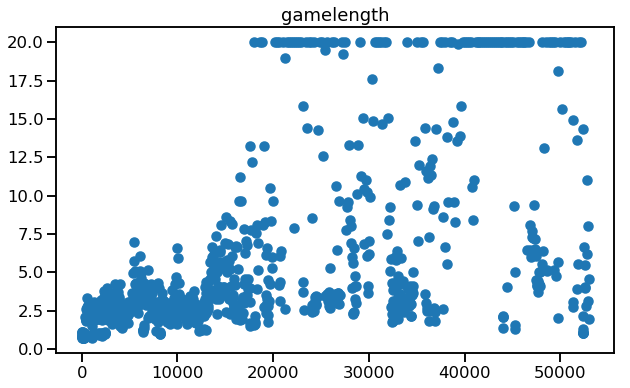

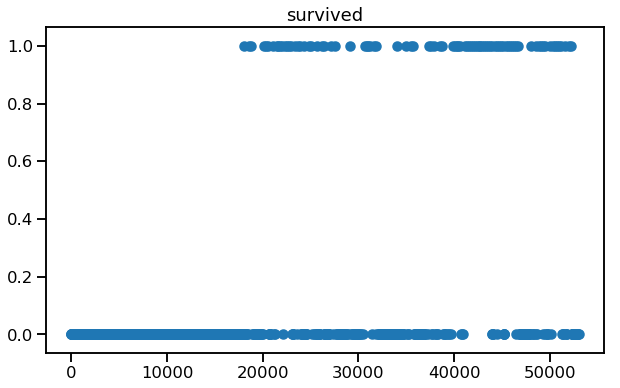

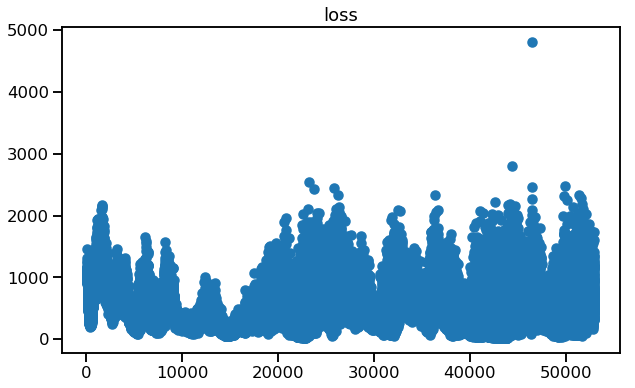

         20656457 function calls (20358515 primitive calls) in 98.732 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    52884   14.292    0.000   14.292    0.000 {method 'run_backward' of 'torch._C._EngineBase' objects}
    52988    8.607    0.000   60.244    0.001 <string>:35(_update)
   423072    6.297    0.000    6.297    0.000 {method 'mul_' of 'torch._C._TensorBase' objects}
   525628    5.938    0.000    6.616    0.000 hover.py:125(step)
   191252    4.734    0.000    4.734    0.000 {method 'matmul' of 'torch._C._TensorBase' objects}
   423072    3.881    0.000    3.881    0.000 {method 'add_' of 'torch._C._TensorBase' objects}
    52884    3.643    0.000   18.657    0.000 adam.py:49(step)
   297020    2.890    0.000   12.499    0.000 functional.py:1390(linear)
    52884    2.846    0.000    2.846    0.000 <string>:39(<listcomp>)
   579527    2.797    0.000    6.221    0.000 hover.py:134(state)
    52988    2.716   

In [9]:
%%prun

class QModel(T.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.in_features = T.nn.Linear(6, hidden_size)
        d = .2 * (self.in_features.in_features) ** -.5
        T.nn.init.uniform_(self.in_features.weight, -d, d)
        self.predict = T.nn.Linear(hidden_size, 4)

    def forward(self, x):
        h = T.relu(self.in_features(x))
        return self.predict(h)

class QAgent:
    def __init__(self):
        # Fixed state (settings)
        self.discount = .95
        self.ticks_per_action = 10
        self.greed = .9
        self.qsteps = 5
        self.max_buffer = 1000
        self.update_sample = 100
        self.max_game_time = 20
        self.actions = [(False, False), (False, True), (True, False), (True, True)]

        # Transient state
        self.model = QModel(10)
        self.buffer = []
        self.random = np.random.RandomState()
        self.pre_buffer = []
        self.opt = T.optim.Adam(self.model.parameters())
        self.log = Log()

    def _update(self):
        if self.update_sample <= len(self.buffer):
            self.opt.zero_grad()
            indices = self.random.randint(0, len(self.buffer), self.update_sample)
            states = T.FloatTensor([self.buffer[idx][0] for idx in indices])
            actions = T.LongTensor([self.buffer[idx][1] for idx in indices])
            rewards = T.FloatTensor([self.buffer[idx][2] for idx in indices])

            y = self.model(states)[T.arange(self.update_sample), actions]
            loss = ((y - rewards) ** 2).sum()
            self.log.append('loss', float(loss))
            loss.backward()
            self.opt.step()

    def _act(self, state, greedy):
        if greedy or self.random.rand() < self.greed:
            return int(T.argmax(self.model(T.FloatTensor(state))))
        else:
            return self.random.randint(len(self.actions))

    def _add_memory(self, state, action, reward):
        if self.qsteps == len(self.pre_buffer):
            sar = self.pre_buffer.pop(0)
            sar[2] += (self.discount ** self.qsteps) * float(T.max(self.model(T.FloatTensor(state))))
            self.buffer.append(sar)
        self.pre_buffer.append([state, action, 0])
        for n in range(len(self.pre_buffer)):
            self.pre_buffer[-1 - n][2] += reward * (self.discount ** n)
        self._update()

    def _flush_and_trim_buffer(self):
        self.buffer += self.pre_buffer
        self.pre_buffer = []
        self.buffer = self.buffer[-self.max_buffer:]

    def train(self):
        """Train the agent with a single game."""
        game = H.Game()
        assert H.in_bounds(game.state), 'should always start in bounds'
        while True:
            state = game.state
            action = self._act(state, greedy=False)
            for _ in range(self.ticks_per_action):
                game.step(*self.actions[action])
                timed_out = self.max_game_time <= game.elapsed
                if timed_out or not H.in_bounds(game.state):
                    self._add_memory(state, action, timed_out)
                    self._flush_and_trim_buffer()
                    self.log.append('gamelength', game.elapsed)
                    self.log.append('survived', timed_out)
                    self.log.tick()
                    return
            self._add_memory(state, action, 1)
            self.log.tick()

    def __call__(self, state):
        """Evaluation policy - greedy as anything."""
        return self.actions[self._act(state, greedy=True)]

game = H.Game()
agent = QAgent()
for _ in range(1000):  # 1000
    agent.train()
agent.log.show()

# qdf = pd.DataFrame.from_dict(
#     [dict(name=name, lifetime=H.single_game_lifetime(agent, 20))
#      for name, agent in [('untrained', QAgent()),
#                          ('trained', agent)]
#      for _ in range(100)])
# plot_lifetime_dist(qdf)

In [93]:
game = H.Game()
display_id = display(game, display_id=True)
while H.in_bounds(game.state):
    for _ in range(10):
        game.step(*agent(game.state))
    display_id.update(game)
    time.sleep(10 * game.timestep)

KeyboardInterrupt: 